In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AviationData.csv to AviationData.csv
Saving USState_Codes.csv to USState_Codes.csv


In [ ]:
!pip install kmodes
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q pyproj==1.9.6

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
# Basic Libraries
import io
import re
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import plotly.express as px
import plotly.graph_objects as go
sb.set() # set the default Seaborn style for graphics

### Initial Exploratory Analysis

In [ ]:
us_statecodes = pd.read_csv('USState_Codes.csv')
us_statecodes.head

<bound method NDFrame.head of           US_State Abbreviation
0          Alabama           AL
1           Alaska           AK
2          Arizona           AZ
3         Arkansas           AR
4       California           CA
..             ...          ...
57  Virgin Islands           VI
58   Washington_DC           DC
59  Gulf of mexico           GM
60  Atlantic ocean           AO
61   Pacific ocean           PO

[62 rows x 2 columns]>

In [ ]:
aviation_data=pd.read_csv('AviationData.csv', encoding = "ISO-8859-1", engine='python', sep=',', quotechar='"', error_bad_lines=False)
aviation_data.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,LOCATION,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,2.02102E+13,Accident,CEN21FA130,2021-02-16,"JANESVILLE, WI",United States,42.595377,-89.030245,NaN,NaN,Fatal,Substantial,Airplane,N13VT,Velocity,Vtwin,No,2.0,NaN,91,NaN,Ferry,NaN,2.0,0.0,0.0,0.0,VMC,NaN,NaN,NaN
1,2.02102E+13,Accident,ERA21FA130,2021-02-15,"St Thomas, CB",United States,18.354444,-65.027778,NaN,NaN,Fatal,Destroyed,Helicopter,N13AT,Bell,206,No,1.0,NaN,91,NaN,Aobv,Caribbean Buzz Management Llc.,4.0,0.0,0.0,0.0,VMC,NaN,NaN,NaN
2,2.02102E+13,Accident,ANC21LA017,2021-02-13,"TYONEK, AK",United States,61.336392,-152.016430,NaN,NaN,Minor,Substantial,Airplane,N56517,Maule,M-6-235,No,1.0,NaN,91,NaN,Personal,Paul Andrews,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN
3,2.02102E+13,Accident,CEN21LA127,2021-02-12,"PRAIRIE DU SAC, WI",United States,43.297731,-89.755693,91C,SAUK-PRAIRIE,Non-Fatal,Substantial,Airplane,N3477E,Cessna,172N,No,1.0,NaN,91,NaN,Instructional,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,NaN
4,2.02102E+13,Accident,ERA21LA131,2021-02-10,"LAKE PLACID, FL",United States,27.243723,-81.413767,09FA,NaN,Minor,Substantial,Airplane,N8183C,Piper,PA-18,No,1.0,NaN,91,NaN,Personal,Case Robert,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN


Counting the number of fatalities around the world

In [ ]:
Accidents = aviation_data['Country'].groupby(aviation_data['Country']).count()
Accidents

Country
Afghanistan       14
Albania            1
Algeria            5
American Samoa    10
Angola            11
                  ..
Vietnam            5
West Indies       11
Yemen              1
Zambia             2
Zimbabwe           4
Name: Country, Length: 185, dtype: int64

Distribution of injuries or fatalities in the world

In [ ]:
aviation_State = pd.DataFrame(aviation_data['Total.Fatal.Injuries']+aviation_data['Total.Serious.Injuries']+aviation_data['Total.Minor.Injuries'])
aviation_State = aviation_State.rename(columns={0:"Injuries/Fatalities"})
aviation_merged = pd.concat([aviation_data,aviation_State], axis=1)
aviation_merged.head()

aviation_merged['text'] = aviation_merged['Country'] + '<br>Injuries/Fatalities ' + (aviation_merged['Injuries/Fatalities'].astype(str))
colors = ["darkblue","yellow","seagreen","purple","cyan","orange"]
limits = [(0,50),(50,100),(100,150),(150,175),(175,200),(350,400)]
#scale = 10
accidentState = []

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    Injuries_Count = aviation_merged[((aviation_merged['Injuries/Fatalities'] > lim[0]) & (aviation_merged['Injuries/Fatalities'] <lim[1]))]
    fig.add_trace(go.Scattergeo(
        locationmode = 'country names',
        lon = Injuries_Count['Longitude'],
        lat = Injuries_Count['Latitude'],
        opacity = 0.8,
        text = Injuries_Count['text'],
        marker = dict(
            size = Injuries_Count['Injuries/Fatalities'],
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))
    accidentState.append(Injuries_Count)

fig.update_layout(
        title_text = 'Distribution of Injuries/Fatalities in the World<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'world',
            landcolor = 'rgb(217, 217, 217)',
        )
    )
fig.show()

These plots give us an overview of the different accidents that have taken place at different times of flight





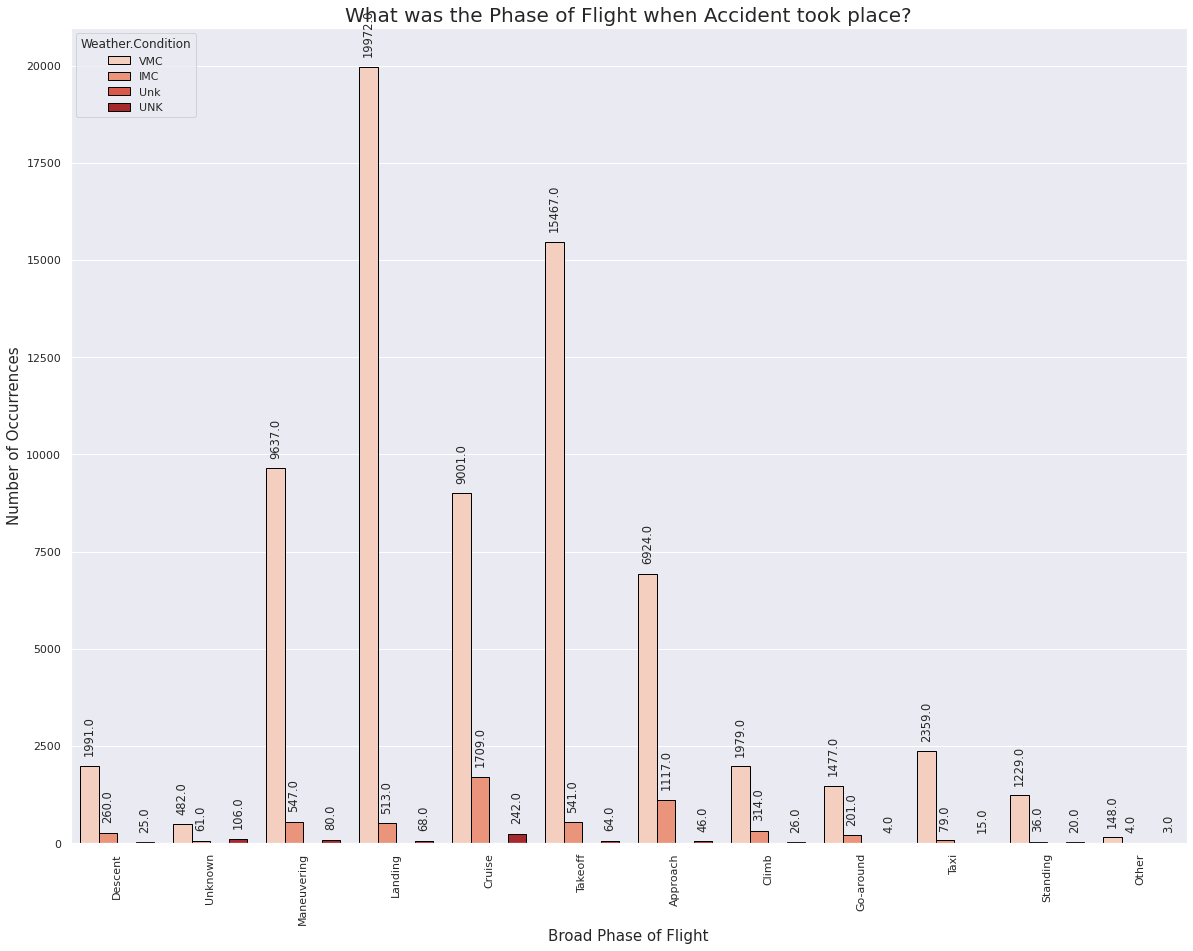

In [ ]:
plt.figure(figsize=(20,15))
splot = sb.countplot(data=aviation_merged, x="Broad.phase.of.flight", hue='Weather.Condition', edgecolor=(0,0,0), linewidth=1, palette='Reds')
plt.xticks(rotation=90)
plt.xlabel("Broad Phase of Flight", size=15)
plt.ylabel("Number of Occurrences", size=15)
plt.title("What was the Phase of Flight when Accident took place?", size=20)
for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., 
    p.get_height()), ha = 'center', va = 'bottom', xytext = (0, 10), textcoords = 'offset points', rotation=90, size=11.5)
plt.show()

Companies of the aircraft involved in the accident

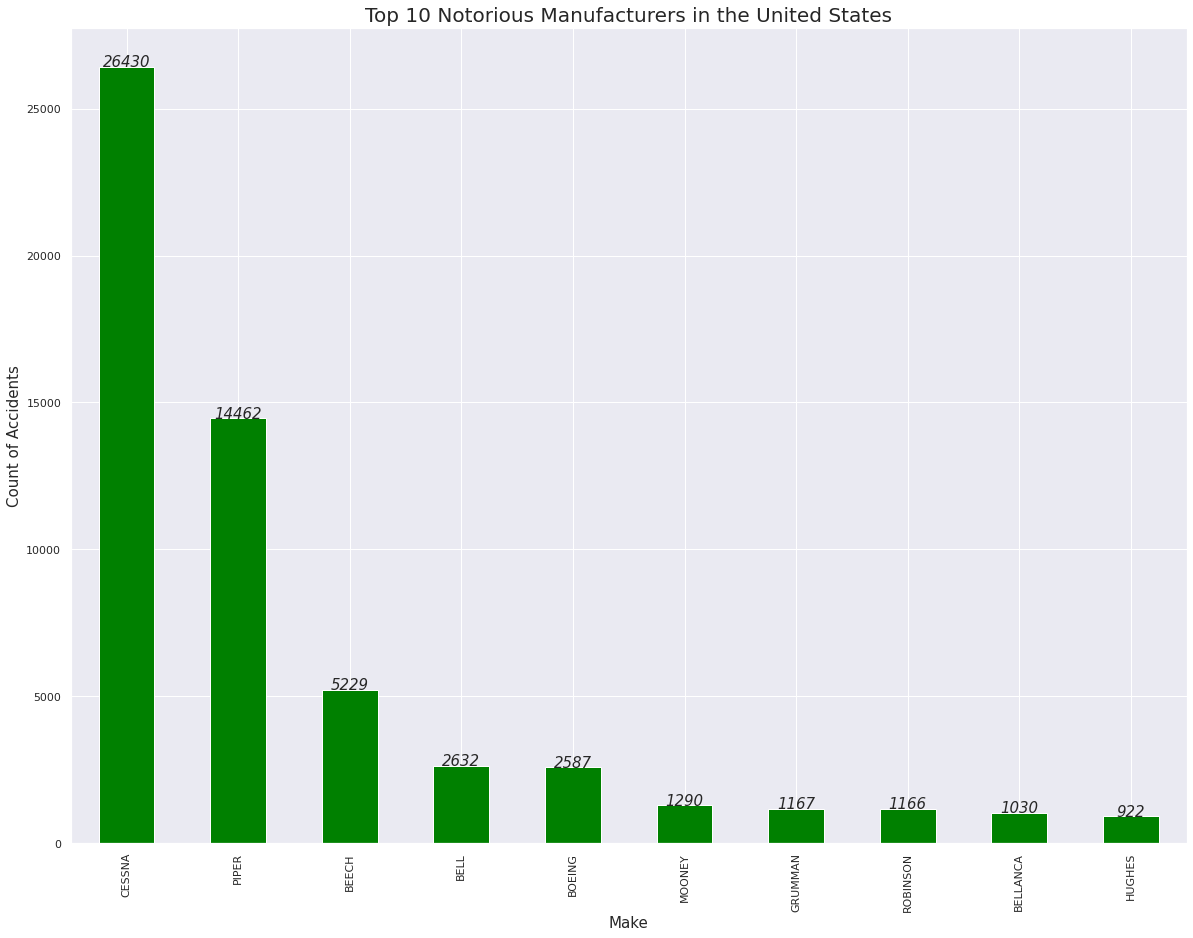

In [ ]:
plt.figure(figsize=(20,15))
aviation_data['Make'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Green')
plt.xticks(rotation=90)
plt.xlabel("Make", size=15)
plt.ylabel("Count of Accidents", size=15)
plt.title("Top 10 Notorious Manufacturers in the United States", size=20)
y=aviation_data['Make'].str.upper().value_counts().sort_values(ascending=False)[:10]
for i, v in enumerate(y):
    plt.text(i, v, str(v), fontsize=15, style='oblique', horizontalalignment='center')
plt.show()

Analysis of notorious models of aircraft involved in accidents


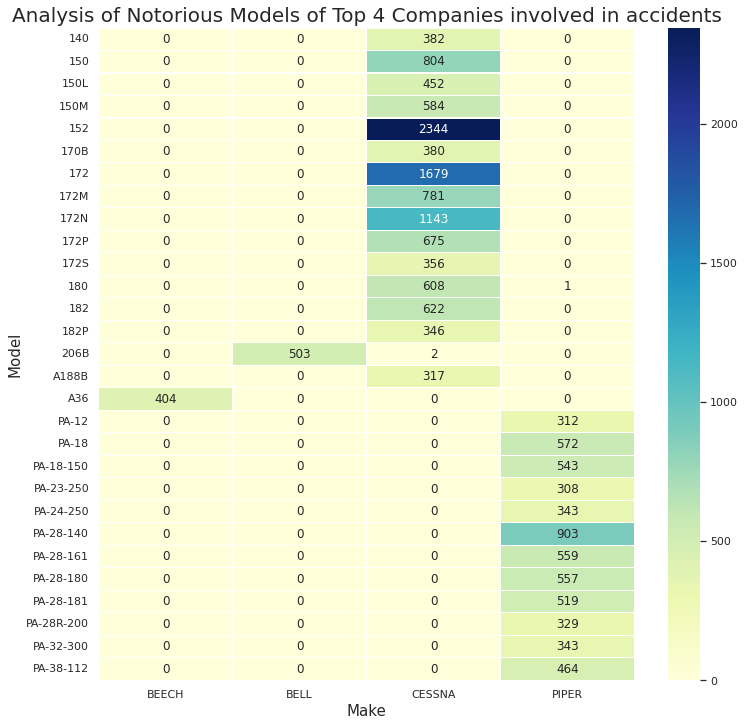

In [ ]:
# Load the example flights dataset and convert to long-form 
# Changing the formatting of the flight manufacturers to uppercase
data1 = aviation_merged[aviation_merged['Make'].str.upper().isin(["CESSNA","PIPER","BEECH","BELL"])]
data2 = data1.replace('Cessna','CESSNA')
data3 = data2.replace('Bell','BELL')
data4 = data3.replace('Beech','BEECH')
data = data4.replace('Piper','PIPER')
# Using Pivot table function of pandas
table1 = pd.pivot_table(data, index=['Model'], columns=['Make'], values='Event.Date', aggfunc=np.count_nonzero, fill_value=0)
table2 = table1[(table1.values > 300)]

# Draw a heatmap with the numeric values in each cell
fig, ax = plt.subplots(figsize=(12, 12))
sb.heatmap(table2, annot=True, fmt="d", linewidths=.1, ax=ax, linecolor='white', cmap='YlGnBu')
plt.xlabel("Make", size=15)
plt.ylabel("Model", size=15)
plt.title("Analysis of Notorious Models of Top 4 Companies involved in accidents", size=20)
fig.show()

Which part of the year did most of the accidents take place ?


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

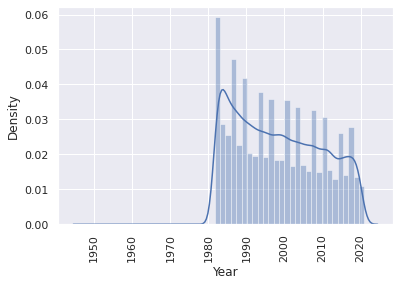

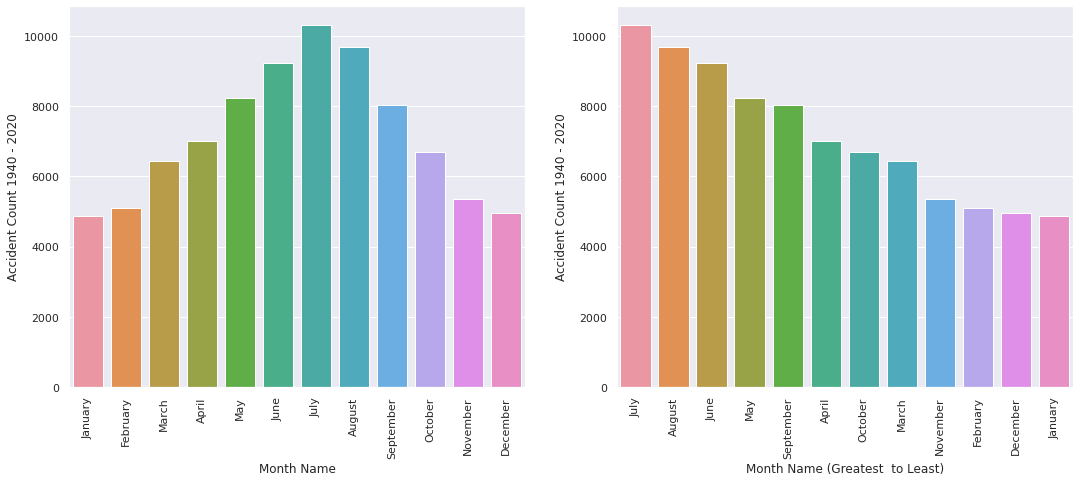

In [ ]:
aviation_merged['Year'] = pd.DatetimeIndex(aviation_merged['Event.Date']).year
aviation_merged['Month'] = pd.DatetimeIndex(aviation_merged['Event.Date']).month_name()
aviation_merged.head()

sb.distplot(a = aviation_merged['Year'], bins  = 52, kde= True)
plt.xticks(rotation = 90)

fig = plt.figure(figsize = (18,7))
fig.add_subplot(1,2,1)
sb.countplot(x = aviation_merged['Month'] , data = aviation_data, order  =  ['January', 'February','March', 'April','May',  'June','July', 'August', 'September', 'October','November','December']).set(xlabel= 'Month Name', ylabel = "Accident Count 1940 - 2020")
plt.xticks(rotation = 90)

fig.add_subplot(1,2,2)
sb.countplot(x = aviation_merged['Month'], 
              data = aviation_data,  
              order = aviation_merged['Month'].value_counts()[:].index).set(xlabel= 'Month Name (Greatest  to Least)',  ylabel = "Accident Count 1940 - 2020")
plt.xticks(rotation = 90)

Engine type of the aircraft involved in the accident

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3750: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



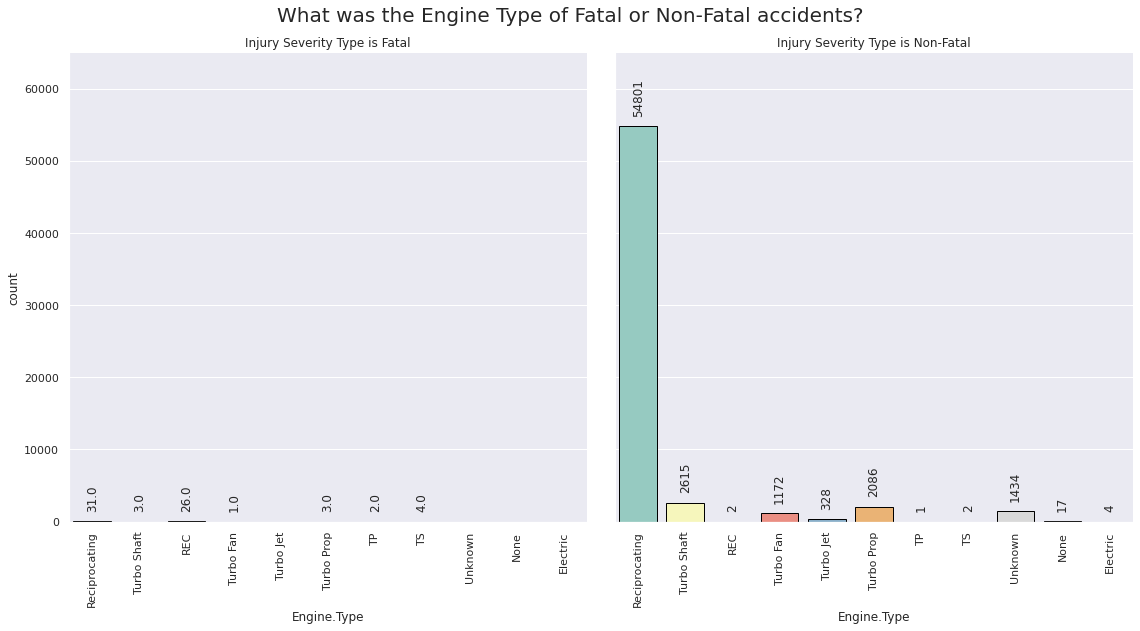

In [ ]:
cplot = sb.catplot(x="Engine.Type", col="Injury.Severity", kind="count", col_wrap=2,
                  data=aviation_merged[aviation_merged['Injury.Severity'].isin(['Fatal','Non-Fatal'])], 
                  legend_out=True, size=8, palette="Set3", edgecolor=(0,0,0))
cplot.set_xticklabels(rotation=90)
cplot.fig.suptitle("What was the Engine Type of Fatal or Non-Fatal accidents?", size=20)
cplot.fig.subplots_adjust(top=.9)
cplot.set_titles("Injury Severity Type is {col_name}")
cplot.set(ylim=[0,65000])
for ax in cplot.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, 
        p.get_height()), ha = 'center', va = 'bottom', xytext = (0, 10), textcoords = 'offset points', rotation=90, size=12)
plt.show()

#### Basic cleaning of the dataset

In [ ]:
#Reformatting the date
aviation_data['Year'] = [int(i.split('-')[0]) for i in aviation_data['Event.Date']]
aviation_data['Month'] = [int(i.split('-')[1]) for i in aviation_data['Event.Date']]
aviation_data['Day'] = [int(i.split('-')[2]) for i in aviation_data['Event.Date']]
#del aviation_data['Event.Date']

Performing encoding on the data: Encoding allows the representation of categorical data to be more expressive. Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers.

In [ ]:
# Modifying dataset so as to improve cleaning of the dataset
aviation_data['LOCATION'] = aviation_data["LOCATION"].str.upper() #making all CAPS
aviation_data['LOCATION'].fillna('unknown',inplace = True) #removing nan
aviation_anomaly_data=aviation_data.dropna(subset=['Latitude', 'Total.Fatal.Injuries', "Total.Serious.Injuries", "Total.Minor.Injuries"]) #removing columns with values of 'nan'           
#removing locations with frequency less than 100 for faster computing 
col = 'LOCATION'  # 'bar'
n = 100  # 2
aviation_data_filtered  = aviation_data[aviation_data.groupby(col)[col].transform('count').ge(n)]

# Cleaning some of the predictors

aviation_data['Make'] = aviation_data["Make"].str.lower()
aviation_data['Engine.Type'].fillna('None',inplace = True)
aviation_data['Weather.Condition'].fillna('unknown',inplace = True)
aviation_data['Purpose.of.flight'].fillna('unknown',inplace=True)
# Cleaning some of the outcomes
aviation_data.loc[(aviation_data['Injury.Severity'] != "Non-Fatal") & (aviation_data['Injury.Severity'] != "Incident"), 'Injury.Severity'] = 'Fatal'
aviation_data.loc[(aviation_data['Injury.Severity'] == "Incident"), 'Injury.Severity'] = 'Fatal'
aviation_data['Injury.Severity'].value_counts()

aviation_data['Aircraft.damage'].fillna('unknown',inplace = True)
aviation_data.loc[(aviation_data['Aircraft.damage'] != "Destroyed") , 'Aircraft.Damage'] = 'Substantial'
aviation_data['Aircraft.damage'].value_counts()


#Removing columns that do not hold any true value to prediction or clustering (anomaly detection)
list_to_drop = ['Event.Id','Investigation.Type','Accident.Number','Event.Date','Country','Report.Status','Publication.Date']
aviation_data_filtered = aviation_data_filtered.drop(list_to_drop, axis=1)

# Creating "ratio" which consisted of the number of total fatal injuries to the total injuries
aviation_data['ratio'] = aviation_data['Total.Fatal.Injuries']/(aviation_data['Total.Uninjured']+aviation_data['Total.Serious.Injuries']+aviation_data['Total.Minor.Injuries']+aviation_data['Total.Fatal.Injuries'])
#aviation_data['ratio'].fillna('unknown',inplace=True)

# Removing the nan values for performing clustering
aviation_data.dropna(subset=['Make','Engine.Type','Amateur.Built',
                'Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries'],
        inplace = True)
#Encoding of categorical variables
aviation_data['Investigation.Type'] = aviation_data['Investigation.Type'].astype('category').cat.codes
aviation_data['Aircraft.damage'] = aviation_data['Aircraft.damage'].astype('category').cat.codes
aviation_data['Aircraft.Category'] = aviation_data['Aircraft.Category'].astype('category').cat.codes
aviation_data['Engine.Type'] = aviation_data['Engine.Type'].astype('category').cat.codes
aviation_data['Injury.Severity'] = aviation_data['Injury.Severity'].astype('category').cat.codes
aviation_data['Make'] = aviation_data['Make'].astype('category').cat.codes
aviation_data['Purpose.of.flight'] = aviation_data['Purpose.of.flight'].astype('category').cat.codes
aviation_data['Weather.Condition'] = aviation_data['Weather.Condition'].astype('category').cat.codes
aviation_data['Broad.phase.of.flight'] = aviation_data['Broad.phase.of.flight'].astype('category').cat.codes
aviation_data['Amateur.Built'] = aviation_data['Amateur.Built'].astype('category').cat.codes
#aviation_data['ratio']=aviation_data['ratio'].astype('category').cat.codes

Checking for the correlation of Variables by using a confusion matrix


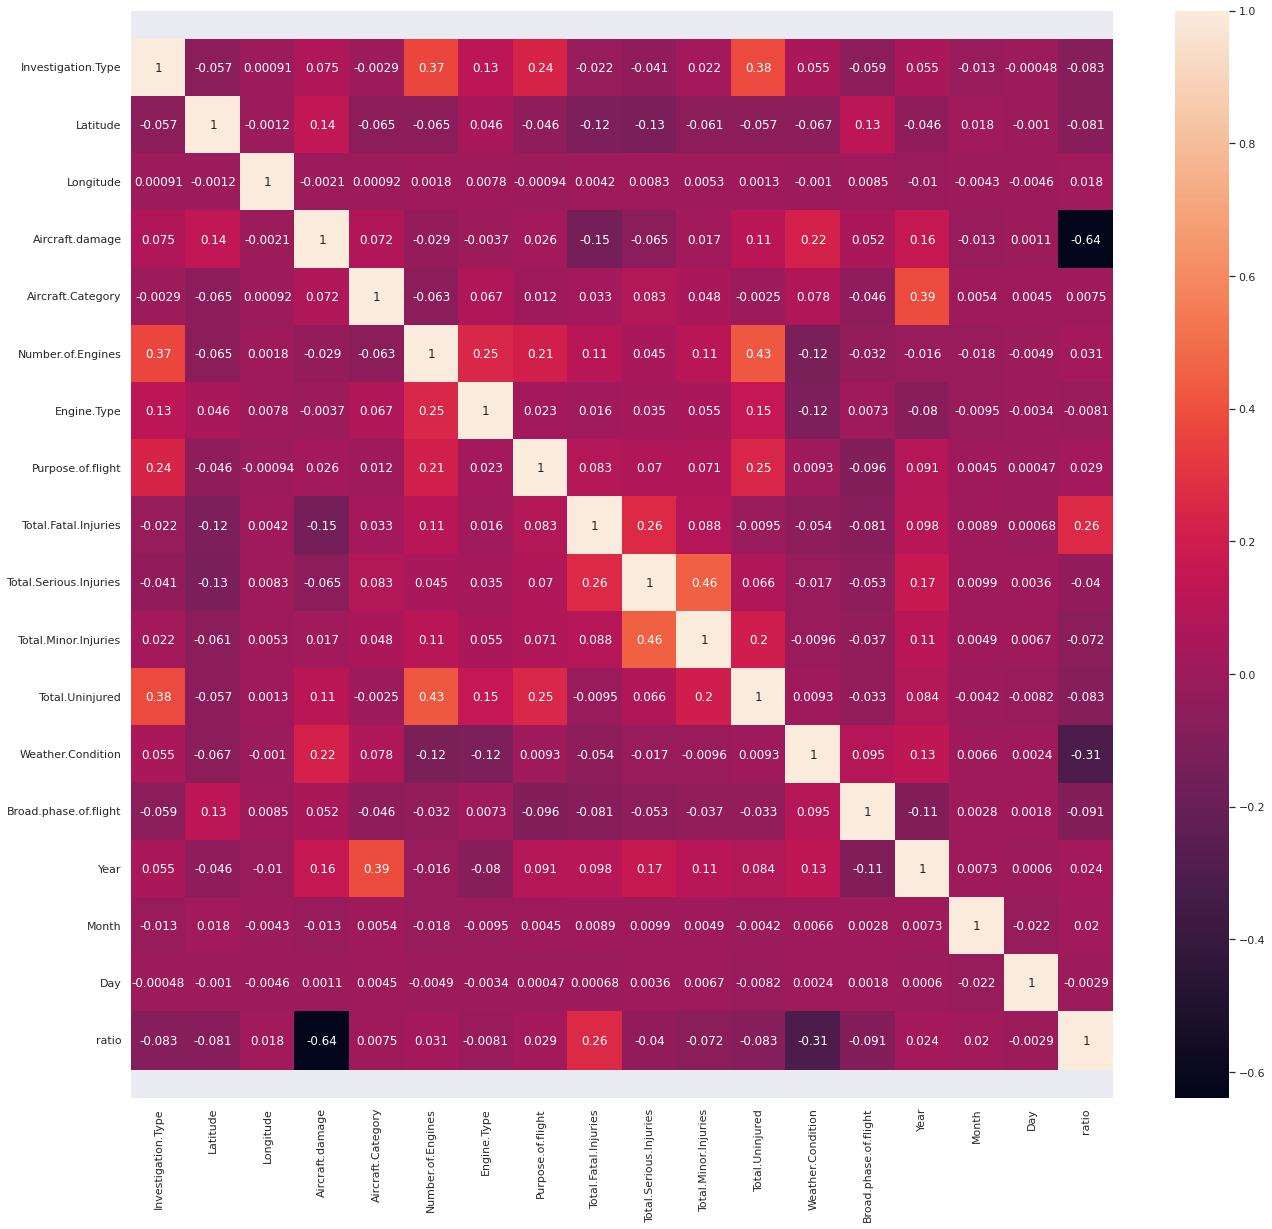

In [ ]:
def plot_correlation_map( df ):
    corr = df.corr()
    f,axes = plt.subplots(figsize=(22,20))
    g = sb.heatmap(corr,annot=True,ax=axes)
    bottom, top = g.get_ylim()
    g.set_ylim(bottom+0.5,top-0.5)    # fix annotation not centered 

plot_correlation_map(aviation_data)

Performing anomaly detection comparing latitude and total fatal injuries

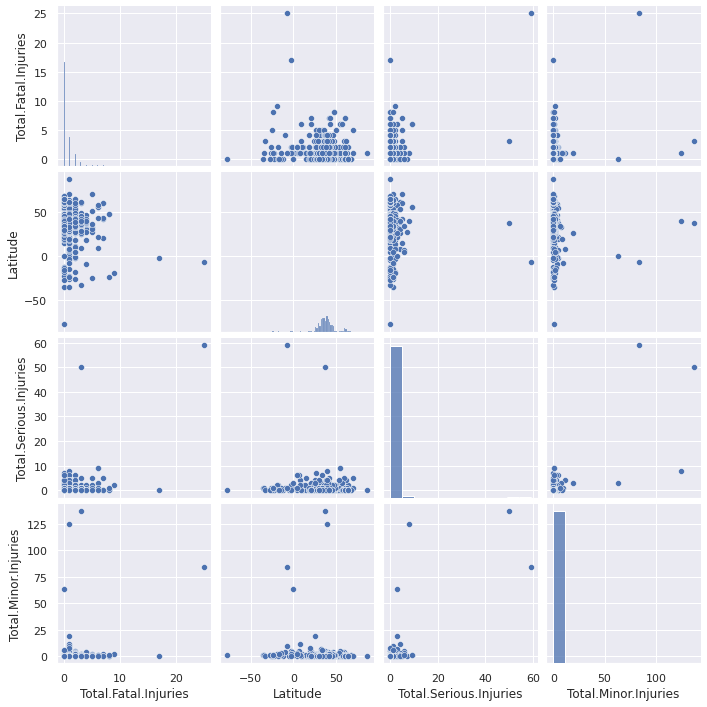

In [ ]:
from sklearn.ensemble import IsolationForest

aviation_anomaly_data_df = pd.DataFrame(aviation_anomaly_data[["Total.Fatal.Injuries", "Latitude", "Total.Serious.Injuries", "Total.Minor.Injuries"]])

# Plot the Raw Data on 2D grids
sb.pairplot(aviation_anomaly_data_df)

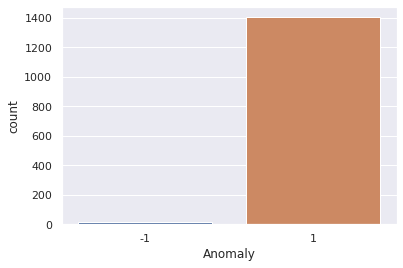

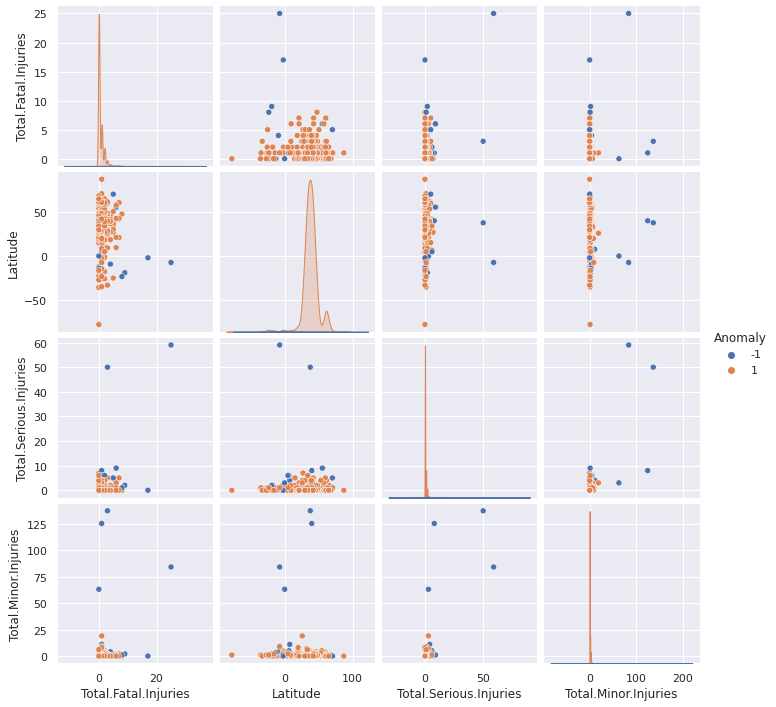

In [ ]:
# Set the Parameters for Neighborhood
num_neighbors = 20      # Number of Neighbors
cont_fraction = 0.01    # Fraction of Anomalies

model = IsolationForest (n_estimators = num_neighbors, contamination = cont_fraction)
model.fit(aviation_anomaly_data_df)
pred = model.predict(aviation_anomaly_data_df)

# Append Labels to the Data
aviation_anomaly_data_df_labeled = aviation_anomaly_data_df.copy()
aviation_anomaly_data_df_labeled["Anomaly"] = pd.Categorical(pred)

# Summary of the Anomaly Labels
sb.countplot(x = aviation_anomaly_data_df_labeled["Anomaly"] , y = None)

# Visualize the Anomalies in the Data
sb.pairplot(aviation_anomaly_data_df_labeled, vars = aviation_anomaly_data_df.columns.values, hue = "Anomaly")

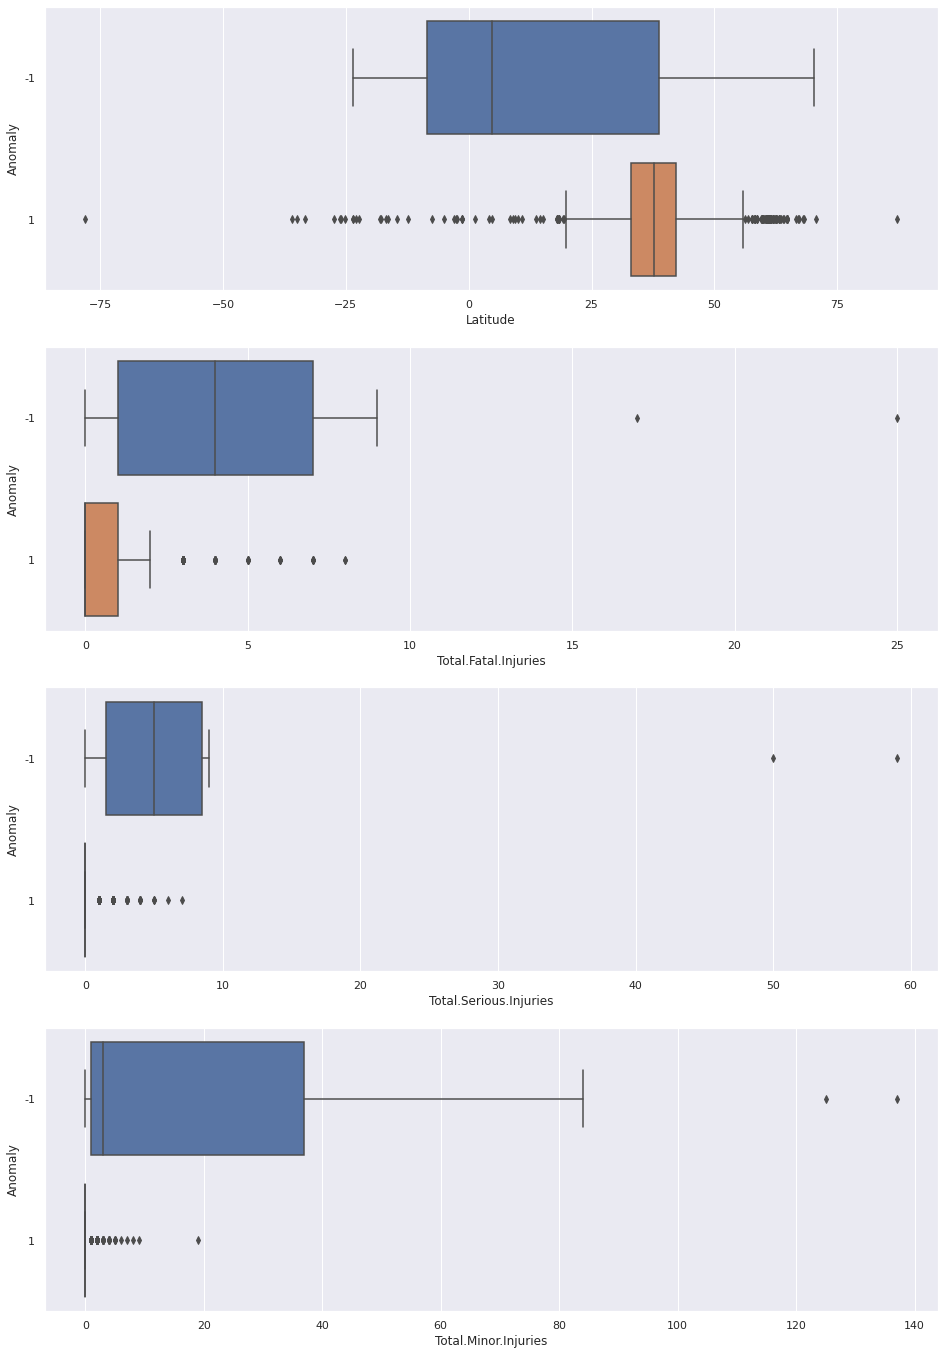

In [ ]:
# Boxplots for all Features against the Anomalies
f, axes = plt.subplots(4, 1, figsize=(16,24))
sb.boxplot(x = 'Latitude', y = 'Anomaly', data = aviation_anomaly_data_df_labeled, ax = axes[0])
sb.boxplot(x = 'Total.Fatal.Injuries', y = 'Anomaly', data = aviation_anomaly_data_df_labeled, ax = axes[1])
sb.boxplot(x = 'Total.Serious.Injuries', y = 'Anomaly', data = aviation_anomaly_data_df_labeled, ax = axes[2])
sb.boxplot(x = 'Total.Minor.Injuries', y = 'Anomaly', data = aviation_anomaly_data_df_labeled, ax = axes[3])

K-Means and K-Modes Clustering

Clustering based on location


In [ ]:
#Selecting variables for clustering 
aviation_cluster = aviation_data[['LOCATION','Injury.Severity','Aircraft.Damage','Make','Amateur.Built','Engine.Type']]
#Removing of unkwown values
aviation_cluster=aviation_cluster.replace(np.nan,"unknown",regex=True)

In [ ]:
#importing the necessary modules
from kmodes.kmodes import KModes
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(aviation_cluster) #stores the prediction in a list 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 178343.0


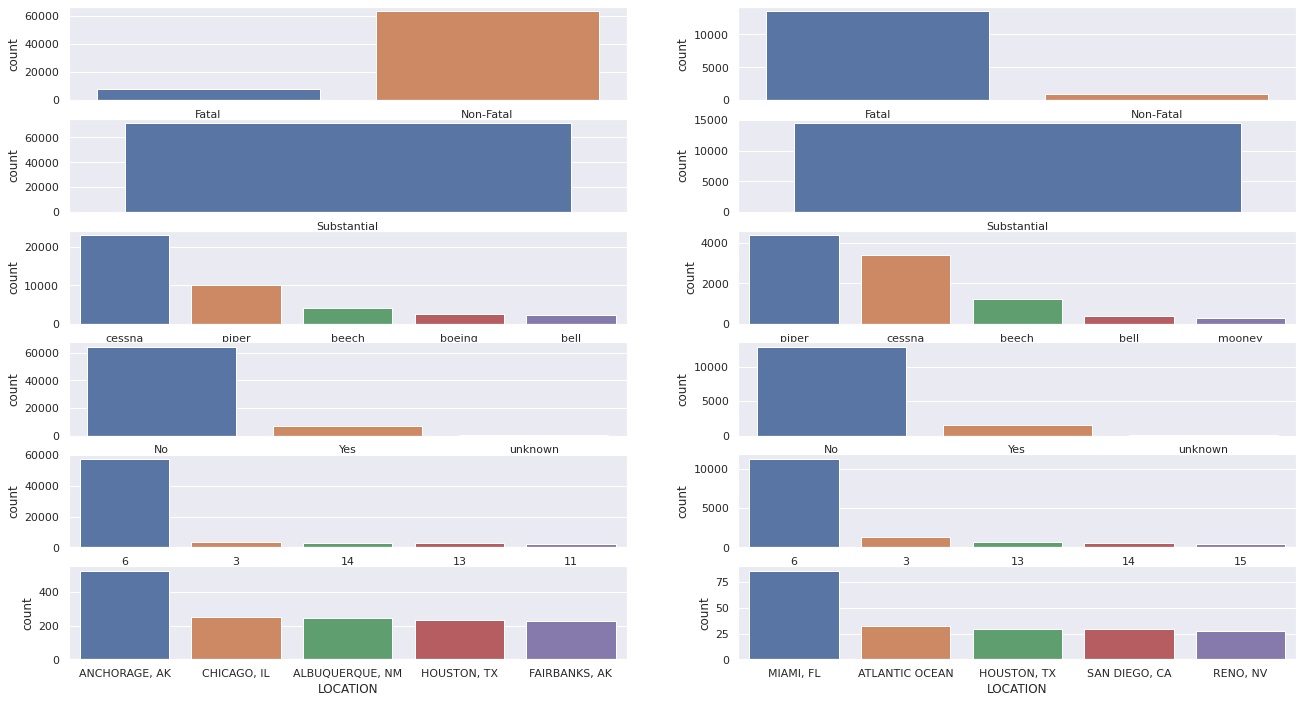

In [ ]:
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([aviation_cluster, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index'], axis = 1)

# splitting outcome into  different cluster dataframes
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]

#Exploratory analysis of clustering
f, axes = plt.subplots(6,2 ,figsize=(22, 12))

sb.countplot(x ='Injury.Severity' , data =cluster_0 , ax = axes[0,0] )
sb.countplot(x ='Aircraft.Damage' , data =cluster_0 , ax = axes[1,0] )
sb.countplot(x ='Make' , data =cluster_0 , ax = axes[2,0] ,order = pd.value_counts(cluster_0['Make']).iloc[:5].index)
sb.countplot(x ='Amateur.Built' , data =cluster_0 , ax = axes[3,0] )
sb.countplot(x ='Engine.Type' , data =cluster_0 , ax = axes[4,0],order = pd.value_counts(cluster_0['Engine.Type']).iloc[:5].index)
sb.countplot(x ='LOCATION' , data =cluster_0 , ax = axes[5,0],order = pd.value_counts(cluster_0['LOCATION']).iloc[:5].index)


sb.countplot(x ='Injury.Severity' , data =cluster_1 , ax = axes[0,1] )
sb.countplot(x ='Aircraft.Damage' , data =cluster_1 , ax = axes[1,1] )
sb.countplot(x ='Make' , data =cluster_1 , ax = axes[2,1] ,order = pd.value_counts(cluster_1['Make']).iloc[:5].index)
sb.countplot(x ='Amateur.Built' , data =cluster_1 , ax = axes[3,1] )
sb.countplot(x ='Engine.Type' , data =cluster_1 , ax = axes[4,1],order = pd.value_counts(cluster_1['Engine.Type']).iloc[:5].index)
sb.countplot(x ='LOCATION' , data =cluster_1 , ax = axes[5,1],order = pd.value_counts(cluster_1['LOCATION']).iloc[:5].index)


In [ ]:
aviation_data['cluster_predicted'] = combinedDf['cluster_predicted']
aviation_location_data = aviation_data[['LOCATION','Latitude','Longitude','cluster_predicted']]
aviation_location_data = df_location_data.dropna()

cluster0_locs =  df_location_data[df_location_data['cluster_predicted'] == 0]
cluster1_locs =  df_location_data[df_location_data['cluster_predicted'] == 1]

In [ ]:
lat_lon = aviation_location_data[['Longitude', 'Latitude']]
lat_lon.head()

,Longitude,Latitude
0,-89.030245,42.595377
1,-65.027778,18.354444
2,-152.016430,61.336392
3,-89.755693,43.297731
4,-81.413767,27.243723


In [ ]:
#importing necessary libraries for location visualisation
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
centroid_region0 = cluster0_locs.loc[cluster0_locs['LOCATION'] == clusterCentroidsDf.at[0, 'LOCATION']]
centroid_region1 = cluster1_locs.loc[cluster1_locs['LOCATION'] == clusterCentroidsDf.at[1, 'LOCATION']]

<Figure size 432x288 with 0 Axes>

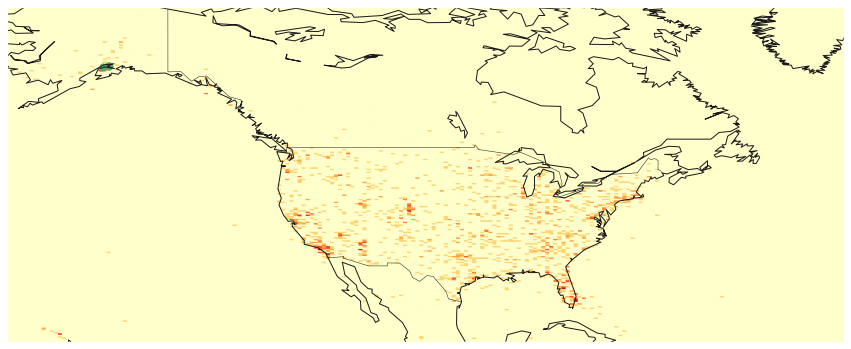

In [ ]:
fig = plt.figure()
plt.figure(figsize=(15,15))

m = Basemap(
    llcrnrlon=-165,
    llcrnrlat=20,
    urcrnrlon=-40,
    urcrnrlat=70,
    projection='cyl',
    resolution='c',
    area_thresh=None,
    rsphere=6370997.0,
    no_rot=False,
    suppress_ticks=True,
    satellite_height=35786000,
    boundinglat=None,
    fix_aspect=True,
    anchor='C',
    celestial=False,
    round=False,
    epsg=None,
    ax=None,
)
x, y = m(cluster1_locs['Longitude'].values, cluster1_locs['Latitude'].values)
m.drawcoastlines()
m.drawcountries()
m.hexbin(x, y, gridsize=1000, bins='log', cmap=cm.YlOrRd)
m.scatter(centroid_region1['Longitude'], centroid_region1['Latitude'], 50, color='g')

Clustering based on ratio of total injuries,weather condition,engine type and make,aircraft category


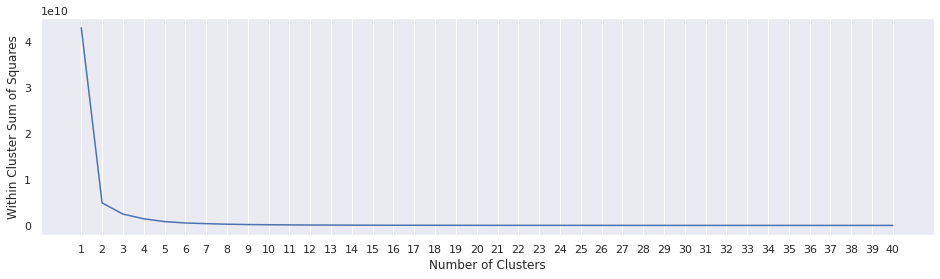

In [ ]:
# Import essential models from sklearn
from sklearn.cluster import KMeans
X = aviation_data[["Engine.Type","Make","Aircraft.Category",'Amateur.Built','Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries']]
X.head()

# Vary the Number of Clusters
min_clust = 1
max_clust = 40
init_algo = 'k-means++'

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust, init = init_algo, n_init = 5)
    kmeans.fit(X)
    within_ss.append(kmeans.inertia_)

# Angle Plot : Within SS vs Number of Clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

Cluster 0:	2.87	517.01	-0.86	0.05	0.49	0.21	0.38	
Cluster 1:	2.82	2316.64	-0.84	0.14	0.46	0.23	0.35	

Within Cluster Sum of Squares : 4901984392.300765



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



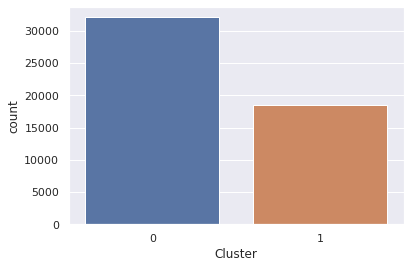

In [ ]:
# Set "optimal" Clustering Parameters
num_clust = 2
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(X)

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()
print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(X)

# Append Labels to the Data
X_labeled = X.copy()
X_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(X_labeled["Cluster"])


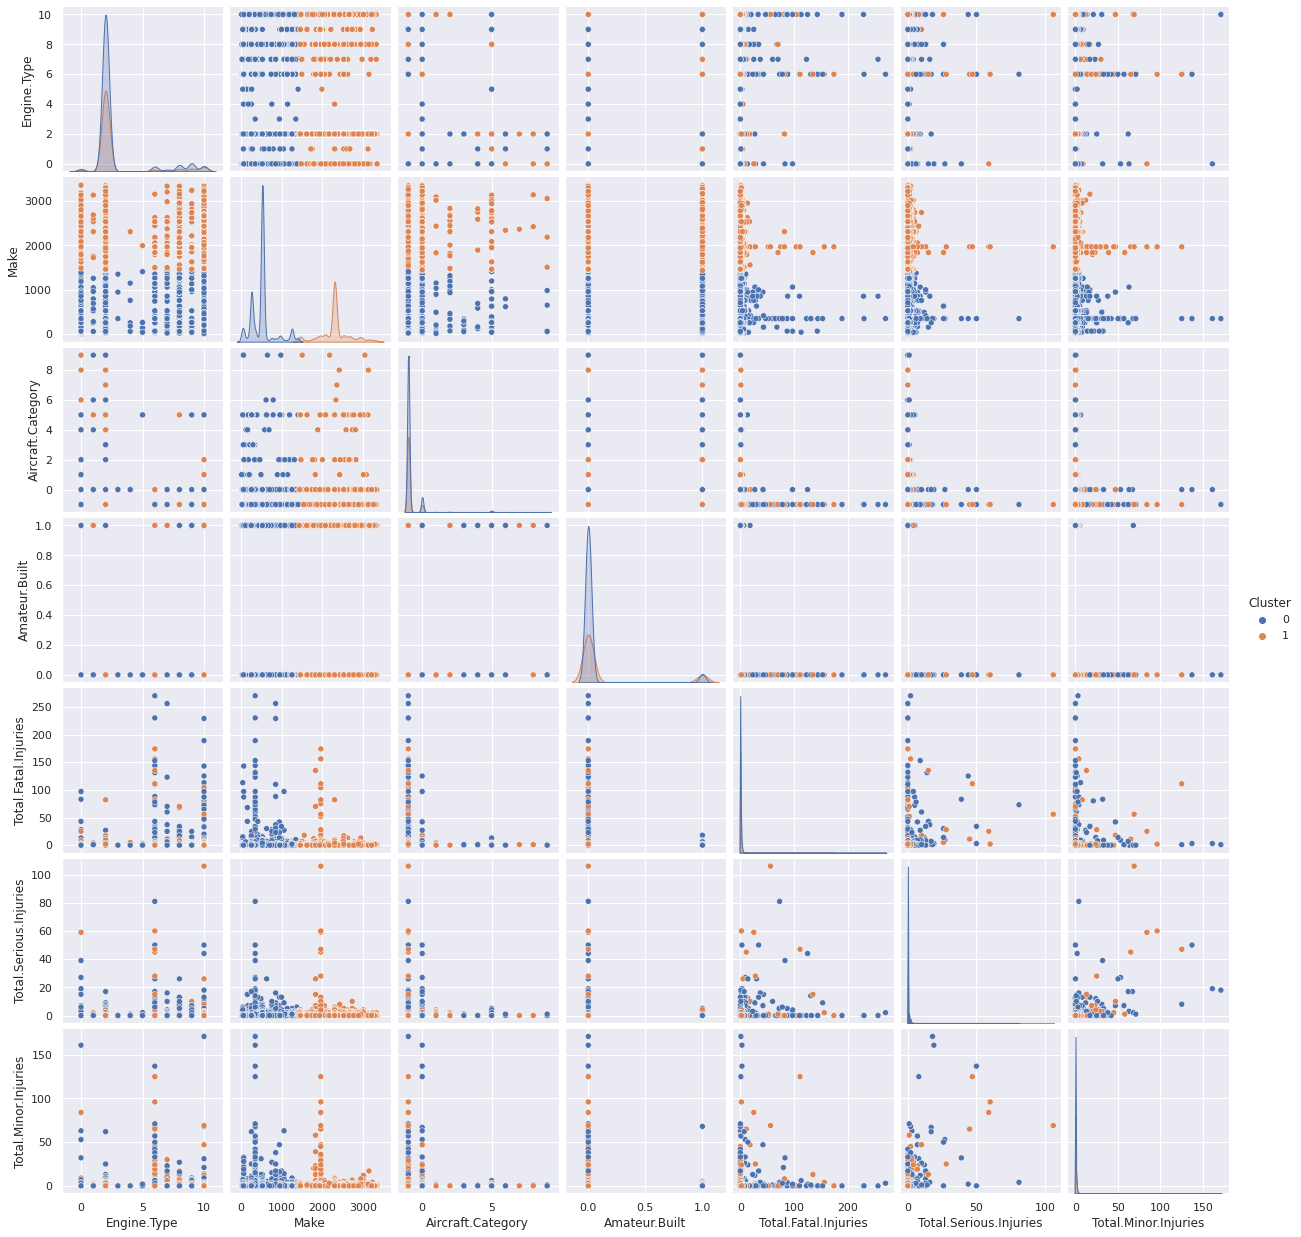

In [ ]:
# Plot the Clusters on 2D grids
sb.pairplot(X_labeled, vars = X.columns.values, hue = "Cluster")